# GFS example 

In [1]:
import Base
import HTTP
import Glob
import Dates
import PyCall
import PyPlot

using LaTeXStrings
using Formatting: printfmt

**Download GFS products from the server**

In [2]:
# selecting date and file name
file_date = Dates.DateTime(2020, 1, 1);
mon_str = Dates.format(file_date, "yyyymm");
date_str = Dates.format(file_date, "yyyymmdd");
file_str = Dates.format(file_date, "yyyymmdd_0000_000.grb2"); # GFS 00Z analysis

# formatting GFS urls
url_download = "https://nomads.ncdc.noaa.gov/data/gfsanl/$mon_str/$date_str/gfsanl_3_$file_str"

# download to a local path
local_path = "/glade/u/home/ksha/WORKSPACE/JL_Collection/data/";
HTTP.download(url_download, local_path, update_period=Inf)

In [3]:
# listing files
filenames = Glob.glob("*.grb2", local_path)

5-element Array{String,1}:
 "/glade/u/home/ksha/WORKSPACE/JL_Collection/data/gfsanl_3_20200101_0000_000.grb2"
 "/glade/u/home/ksha/WORKSPACE/JL_Collection/data/gfsanl_3_20200201_0000_000.grb2"
 "/glade/u/home/ksha/WORKSPACE/JL_Collection/data/gfsanl_3_20200301_0000_000.grb2"
 "/glade/u/home/ksha/WORKSPACE/JL_Collection/data/gfsanl_3_20200401_0000_000.grb2"
 "/glade/u/home/ksha/WORKSPACE/JL_Collection/data/gfsanl_3_20200501_0000_000.grb2"

**Call `pygrib` to get variables**

In [4]:
pygrib = PyCall.pyimport("pygrib")

PyObject <module 'pygrib' from '/glade/work/ksha/anaconda3/lib/python3.7/site-packages/pygrib.cpython-37m-x86_64-linux-gnu.so'>

In [5]:
# get array of grib2 keys
grbio = pygrib.open(filenames[1])
var_table = string.(grbio.select())
grbio.close()

# looking for specific variables
print("GFS 2 metre above ground:\n")
for var in var_table
    if occursin("heightAboveGround:level 2 m", var)
        print("\t$var\n")
    end
end

GFS 2 metre above ground:
	PyObject 415:2 metre temperature:K (instant):regular_ll:heightAboveGround:level 2 m:fcst time 0 hrs:from 202001010000
	PyObject 416:Specific humidity:kg kg**-1 (instant):regular_ll:heightAboveGround:level 2 m:fcst time 0 hrs:from 202001010000
	PyObject 417:2 metre dewpoint temperature:K (instant):regular_ll:heightAboveGround:level 2 m:fcst time 0 hrs:from 202001010000
	PyObject 418:2 metre relative humidity:% (instant):regular_ll:heightAboveGround:level 2 m:fcst time 0 hrs:from 202001010000
	PyObject 419:Apparent temperature:K (instant):regular_ll:heightAboveGround:level 2 m:fcst time 0 hrs:from 202001010000


In [6]:
# selecting 2-m temperature, index = 415
grbio = pygrib.open(filenames[1])
T2m = grbio.select()[415].values
lat, lon = grbio.select()[415].latlons()
grbio.close()

T2m = T2m .- 273.15;

**Call `matplotlib` for visualization**

In [7]:
cmap_cold = PyPlot.ColorMap("viridis");
cmap_warm = PyPlot.ColorMap("plasma_r");
cmap_t2_array = vcat(cmap_cold(0:256), cmap_warm(0:256));

#matplotlib.colors.LinearSegmentedColormap
cmap_t2 = PyPlot.ColorMap("xxx", cmap_t2_array);

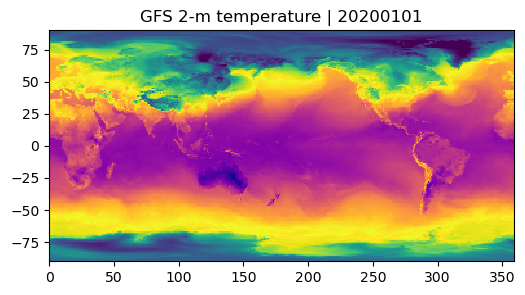

In [8]:
fig = PyPlot.figure(figsize=(6, 3));
ax = fig.gca();
ax.pcolormesh(lon, lat, T2m, vmin=-40, vmax=40, cmap=cmap_t2);
ax.set_title("GFS 2-m temperature | $date_str", fontsize=12);

**Call `matplotlib` and `cartopy` for better visualization**

In [9]:
cartopy = PyCall.pyimport("cartopy")

PyObject <module 'cartopy' from '/glade/work/ksha/anaconda3/lib/python3.7/site-packages/cartopy/__init__.py'>

In [10]:
# features
scale_param = "50m"
PROVINCE = cartopy.feature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale=scale_param,
    facecolor="none")

PyObject <cartopy.feature.NaturalEarthFeature object at 0x2b9be34dfc90>

In [14]:
grid_shape = size(lon);
x = fill(360, (grid_shape[1], 1));
# cyclic mode
lon_cyclic = hcat(lon, x);
lat_cyclic = hcat(lat, lat[:, grid_shape[2]]'');
T2m_cyclic = hcat(T2m, T2m[:, grid_shape[2]]'');

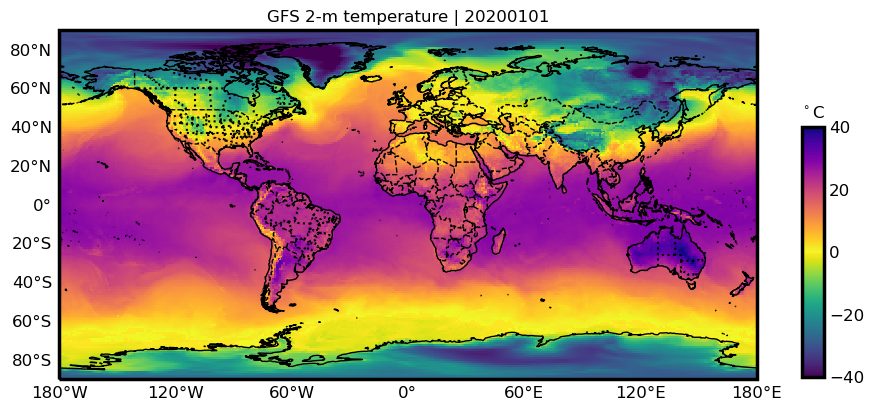

In [16]:
fig = PyPlot.figure(figsize=(9, 5));

ax = fig.gca(projection=cartopy.crs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], cartopy.crs.Geodetic())
ax.add_feature(cartopy.feature.LAND.with_scale(scale_param), facecolor="0.85")
ax.add_feature(cartopy.feature.COASTLINE.with_scale(scale_param))
ax.add_feature(cartopy.feature.BORDERS.with_scale(scale_param), linestyle="--", linewidth=1.0)
ax.add_feature(PROVINCE, edgecolor="k", linestyle=":", linewidth=1.5, zorder=1.0)
ax.outline_patch.set_linewidth(2.5)

GL = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=true, linewidth=0)
GL.xlabels_top = false
GL.ylabels_right = false
GL.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
GL.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
GL.xlabel_style = Dict("size"=>12)
GL.ylabel_style = Dict("size"=>12)

CS = ax.pcolormesh(lon_cyclic, lat_cyclic, T2m_cyclic, vmin=-40, vmax=40, cmap=cmap_t2)
ax.set_title("GFS 2-m temperature | $date_str", fontsize=12);

cax = fig.add_axes([0.95, 0.15, 0.025, 0.5])
CBar = PyPlot.colorbar(CS, orientation="vertical", cax=cax)
CBar.ax.tick_params(axis="y", labelsize=12, direction="in", length=0)
CBar.ax.set_title(L"$\mathsf{^\circ C}$", fontsize=12)
CBar.outline.set_linewidth(2.5)